<a href="https://colab.research.google.com/github/dionysiadimi/matzaris/blob/main/scRNAseq_analysis_of_BCa_samples_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import scipy

In [3]:
!pip install leidenalg

In [4]:
!pip install louvain scanpy

In [5]:
!pip install kb-python

In [6]:
!wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_fastqs.tar

--2023-08-20 22:50:42--  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_fastqs.tar
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5278996480 (4.9G) [application/x-tar]
Saving to: ‘Visium_FFPE_Human_Breast_Cancer_fastqs.tar.1’

Visium_FFPE_Human_B 100%[===================>]   4.92G  15.2MB/s    in 47s     

2023-08-20 22:51:29 (107 MB/s) - ‘Visium_FFPE_Human_Breast_Cancer_fastqs.tar.1’ saved [5278996480/5278996480]



In [7]:
!tar xf Visium_FFPE_Human_Breast_Cancer_fastqs.tar

In [8]:
#Download the human index

In [9]:
!kb ref -d human -i index.idx -g t2g.txt -f1 trascriptome.fasta

[2023-08-20 22:52:32,574]    INFO [download] Skipping download because some files already exist. Use the --overwrite flag to overwrite.


In [10]:
!kb count --h5ad -i index.idx -g t2g.txt -x 10xv1 -o output --filter bustools -t 2 \
Visium_FFPE_Human_Breast_Cancer_fastqs.tar

[2023-08-20 22:52:40,914]    INFO [count] Using index index.idx to generate BUS file to output from
[2023-08-20 22:52:40,914]    INFO [count]         Visium_FFPE_Human_Breast_Cancer_fastqs.tar
[2023-08-20 22:52:41,923]   ERROR [count] kallisto 0.48.0
Generates BUS files for single-cell sequencing

Usage: kallisto bus [arguments] FASTQ-files

Required arguments:
-i, --index=STRING            Filename for the kallisto index to be used for
pseudoalignment
-o, --output-dir=STRING       Directory to write output to

Optional arguments:
-x, --technology=STRING       Single-cell technology used
-l, --list                    List all single-cell technologies supported
-B, --batch=FILE              Process files listed in FILE
-t, --threads=INT             Number of threads to use (default: 1)
-b, --bam                     Input file is a BAM file
-n, --num                     Output number of read in flag column (incompatible with --bam)
-T, --tag=STRING              5′ tag sequence to identif

In [11]:
import scanpy as sc
import anndata



In [12]:
from sklearn.decomposition import TruncatedSVD

In [13]:
import matplotlib

In [14]:
sc.settings.verbosity=3

sc.settings.set_figure_params(dpi=80)


In [15]:
!wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.tar.gz
!wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.h5

--2023-08-20 22:52:47--  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58271640 (56M) [application/x-tar]
Saving to: ‘Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.tar.gz.1’

Visium_FFPE_Human_B 100%[===================>]  55.57M   217MB/s    in 0.3s    

2023-08-20 22:52:48 (217 MB/s) - ‘Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.tar.gz.1’ saved [58271640/58271640]

--2023-08-20 22:52:48--  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:

In [16]:
#load the unfiltered data

results_file= 'data.h5ad'
adata=sc.read_10x_h5("Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.h5")
adata.var["gene_id"] =adata.var.index.values

reading Visium_FFPE_Human_Breast_Cancer_raw_feature_bc_matrix.h5
 (0:00:01)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [17]:
t2g=pd.read_csv("t2g.txt", header=None, names=["tid","gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g=t2g.loc[~t2g.index.duplicated(keep='first')]

In [18]:
adata.var['gene_name']=adata.var.gene_id.map(t2g["gene_name"])
adata.var.index=adata.var

In [19]:
adata.var_names_make_unique()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:887: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [('ENSG00000243485', 'Gene Expression', 'GRCh38', 'MIR1302-2HG', nan), ('ENSG00000237613', 'Gene Expression', 'GRCh38', 'FAM138A', nan), ('ENSG00000186092', 'Gene Expression', 'GRCh38', 'OR4F5', nan), ('ENSG00000238009', 'Gene Expression', 'GRCh38', 'AL627309.1', nan), ('ENSG00000239945', 'Gene Expression', 'GRCh38', 'AL627309.3', nan)]

    Inferred to be: mixed

  names = self._prep_dim_index(names, "var")


In [20]:
adata

AnnData object with n_obs × n_vars = 4992 × 36945
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id', 'gene_name'

In [21]:
# We need to test for library saturation

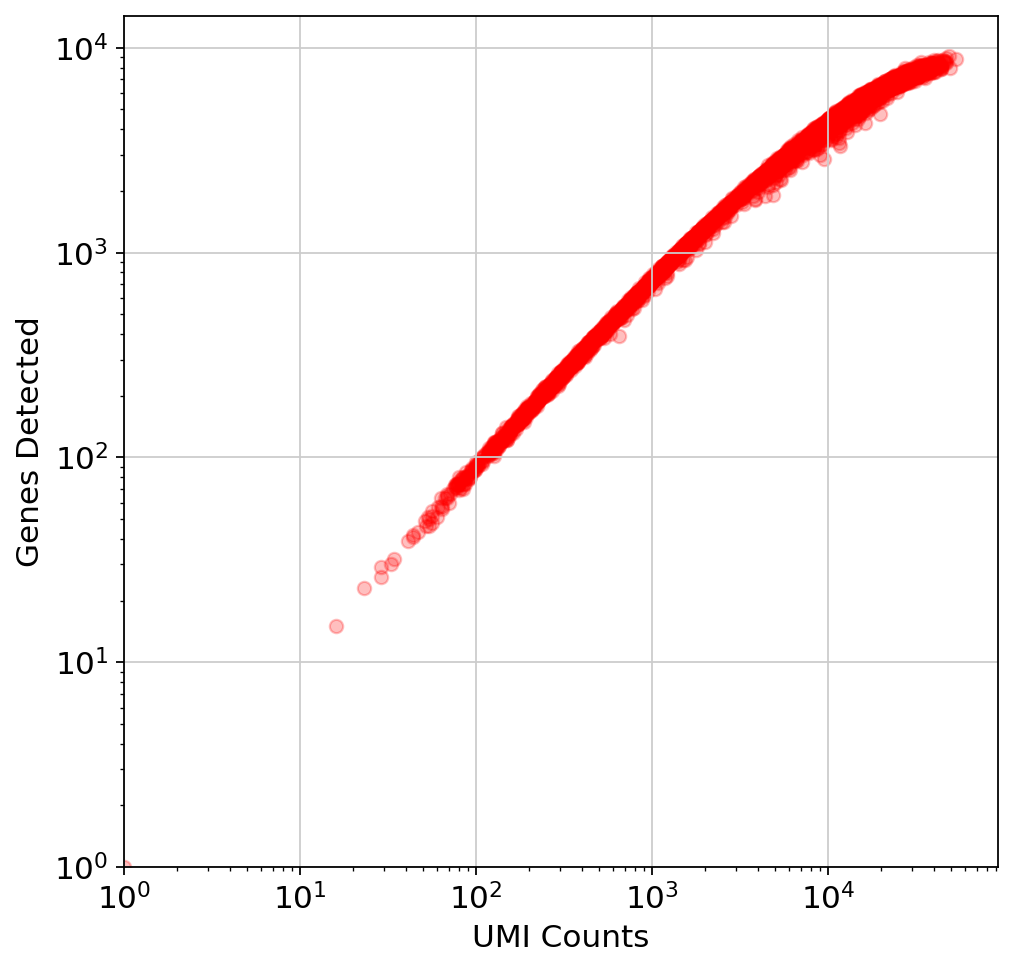

In [22]:
fig, ax=plt.subplots(figsize=(7,7))
x=np.asarray(adata.X.sum(axis=1))[:,0]
y=np.asarray(np.sum(adata.X>0, axis=1))[:,0]
ax.scatter(x,y, color="red", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1)
ax.set_ylim(1)
plt.show()

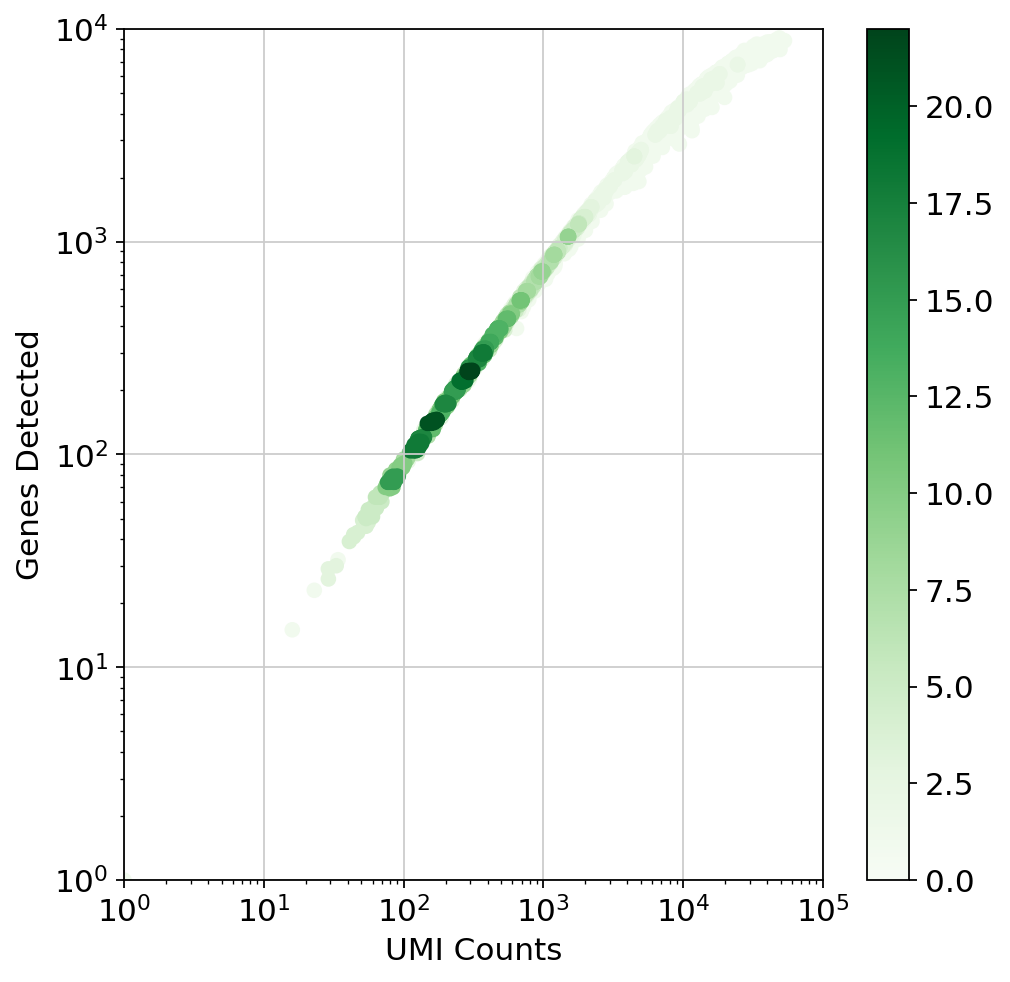

In [23]:
fig, ax=plt.subplots(figsize=(7,7))
bins=[1500, 1500]
hh, locx, locy=np.histogram2d(x,y, bins=bins)
z=np.array([hh[np.argmax(a<=locx[1:]), np.argmax(b<=locy[1:])]for a,b in zip(x,y)])
idx=z.argsort()
x2,y2,z2=x[idx], y[idx], z[idx]

s=ax.scatter(x2,y2, c=z2, cmap="Greens")
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)
plt.show()

In [24]:
#The abovementioned step was to sort the points by density

In [25]:
#The next step is to examine the knee plot

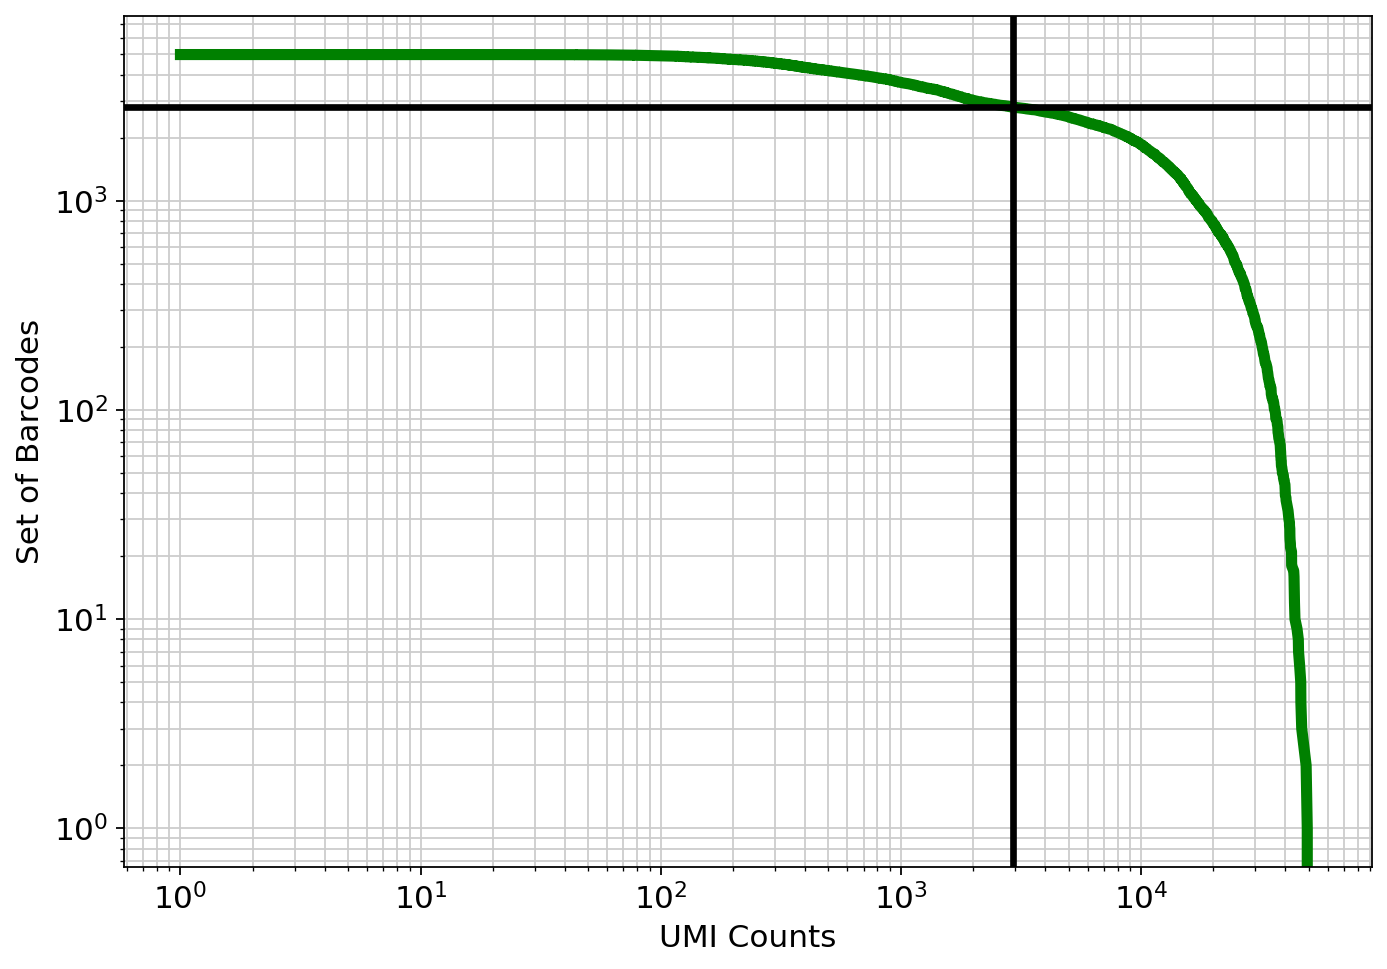

In [26]:
expected_num_cells=2800#@param{type:"integer"}
knee=np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
fig, ax=plt.subplots(figsize=(10,7))
ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")
plt.grid(True, which="both")
plt.show()

In [27]:
#ANALYSIS
#EXAMINE mt genes

normalizing counts per cell
    finished (0:00:00)


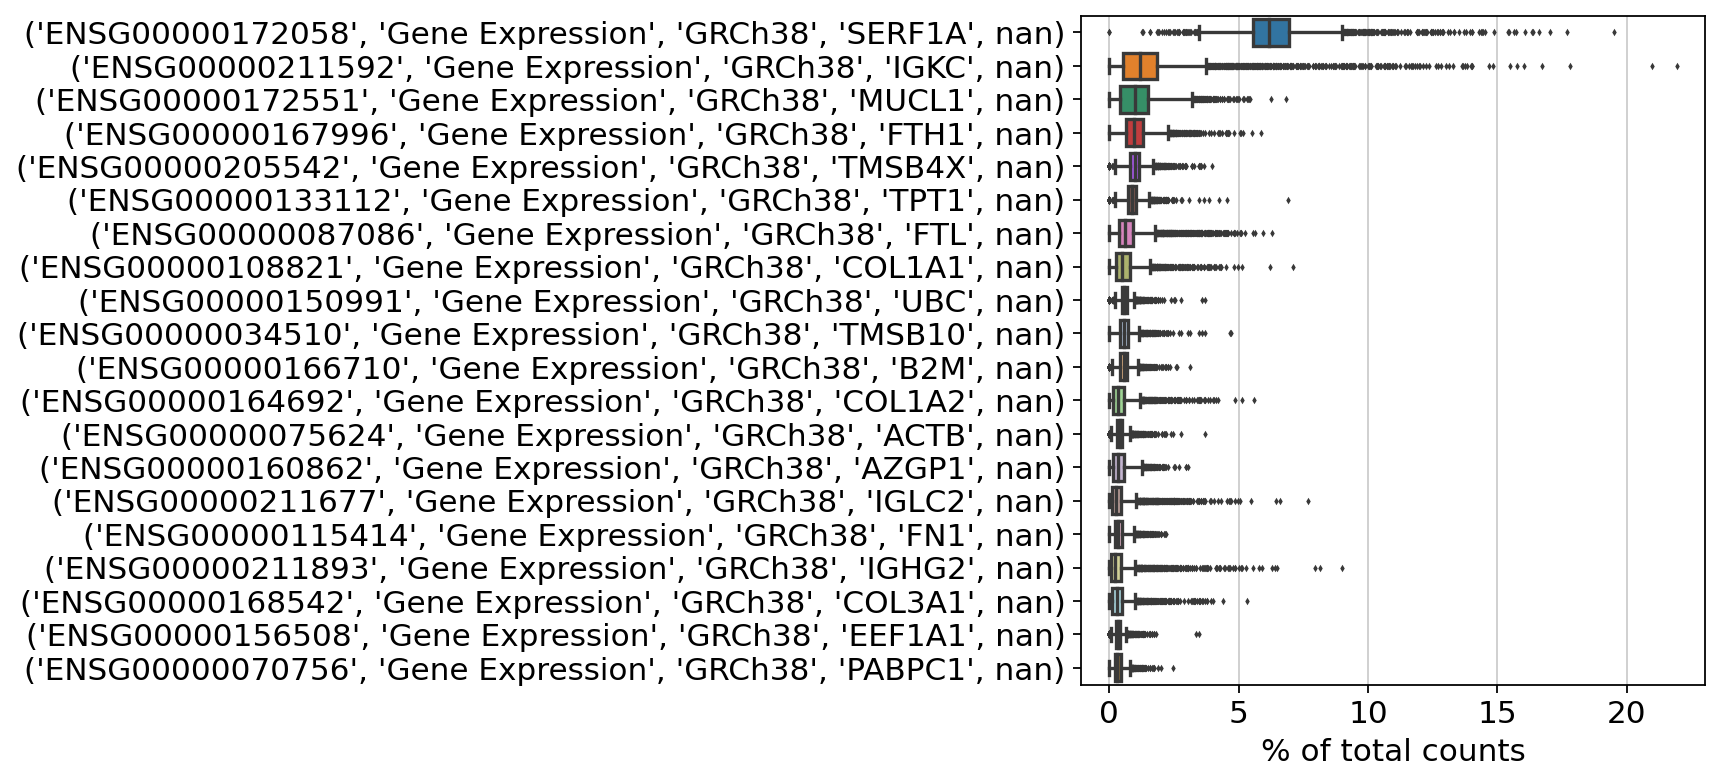

In [28]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [29]:
#NOW WE NEED TO FILTER
#WE need to remove cells with less than 1070 counts

In [30]:
adata=adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) > 1070]

#We need tp remove genes with 0 counts
adata=adata[:, np.asarray(adata.X.sum(axis=0)). reshape(-1) >0]

In [31]:
adata

View of AnnData object with n_obs × n_vars = 3622 × 19172
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id', 'gene_name'

In [32]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


filtered out 858 genes that are detected in less than 3 cells


In [33]:
adata

AnnData object with n_obs × n_vars = 3622 × 18314
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id', 'gene_name', 'n_cells'

In [34]:
#We need to filter for mt gene content -->needs improvement code wrong!

In [35]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))




In [36]:
adata.var

gene_ids  \
(ENSG00000186092, Gene Expression, GRCh38, OR4F...             ENSG00000186092   
(ENSG00000187634, Gene Expression, GRCh38, SAMD...             ENSG00000187634   
(ENSG00000188976, Gene Expression, GRCh38, NOC2...             ENSG00000188976   
(ENSG00000187961, Gene Expression, GRCh38, KLHL...             ENSG00000187961   
(ENSG00000187583, Gene Expression, GRCh38, PLEK...             ENSG00000187583   
...                                                                        ...   
(DEPRECATED_ENSG00000277494, Gene Expression, G...  DEPRECATED_ENSG00000277494   
(DEPRECATED_ENSG00000277632, Gene Expression, G...  DEPRECATED_ENSG00000277632   
(DEPRECATED_ENSG00000280071, Gene Expression, G...  DEPRECATED_ENSG00000280071   
(DEPRECATED_ENSG00000284667, Gene Expression, G...  DEPRECATED_ENSG00000284667   
(DEPRECATED_ENSG00000284704, Gene Expression, G...  DEPRECATED_ENSG00000284704   

                                                      feature_types  genome  \
(ENSG00000186092, Gene Expression, GRCh38, OR4F...  Gene Expression  GRCh38   
(ENSG00000187634, Gene Expression, GRCh38, SAMD...  Gene Expression  GRCh38   
(ENSG00000188976, Gene Expression, GRCh38, NOC2...  Gene Expression  GRCh38   
(ENSG00000187961, Gene Expression, GRCh38, KLHL...  Gene Expression  GRCh38   
(ENSG00000187583, Gene Expression, GRCh38, PLEK...  Gene Expression  GRCh38   
...                                                             ...     ...   
(DEPRECATED_ENSG00000277494, Gene Expression, G...  Gene Expression  GRCh38   
(DEPRECATED_ENSG00000277632, Gene Expression, G...  Gene Expression  GRCh38   
(DEPRECATED_ENSG00000280071, Gene Expression, G...  Gene Expression  GRCh38   
(DEPRECATED_ENSG00000284667, Gene Expression, G...  Gene Expression  GRCh38   
(DEPRECATED_ENSG00000284704, Gene Expression, G...  Gene Expression  GRCh38   

                                                                       gene_id  \
(ENSG00000186092, Gene Expression, GRCh38, OR4F...                       OR4F5   
(ENSG00000187634, Gene Expression, GRCh38, SAMD...                      SAMD11   
(ENSG00000188976, Gene Expression, GRCh38, NOC2...                       NOC2L   
(ENSG00000187961, Gene Expression, GRCh38, KLHL...                      KLHL17   
(ENSG00000187583, Gene Expression, GRCh38, PLEK...                     PLEKHN1   
...                                                                        ...   
(DEPRECATED_ENSG00000277494, Gene Expression, G...  DEPRECATED_ENSG00000277494   
(DEPRECATED_ENSG00000277632, Gene Expression, G...  DEPRECATED_ENSG00000277632   
(DEPRECATED_ENSG00000280071, Gene Expression, G...  DEPRECATED_ENSG00000280071   
(DEPRECATED_ENSG00000284667, Gene Expression, G...  DEPRECATED_ENSG00000284667   
(DEPRECATED_ENSG00000284704, Gene Expression, G...  DEPRECATED_ENSG00000284704   

                                                   gene_name  n_cells  mt  \
(ENSG00000186092, Gene Expression, GRCh38, OR4F...       NaN       14 NaN   
(ENSG00000187634, Gene Expression, GRCh38, SAMD...       NaN       88 NaN   
(ENSG00000188976, Gene Expression, GRCh38, NOC2...       NaN     1041 NaN   
(ENSG00000187961, Gene Expression, GRCh38, KLHL...       NaN      309 NaN   
(ENSG00000187583, Gene Expression, GRCh38, PLEK...       NaN      275 NaN   
...                                                      ...      ...  ..   
(DEPRECATED_ENSG00000277494, Gene Expression, G...       NaN       19 NaN   
(DEPRECATED_ENSG00000277632, Gene Expression, G...       NaN      799 NaN   
(DEPRECATED_ENSG00000280071, Gene Expression, G...       NaN      467 NaN   
(DEPRECATED_ENSG00000284667, Gene Expression, G...       NaN        3 NaN   
(DEPRECATED_ENSG00000284704, Gene Expression, G...       NaN        4 NaN   

                                                    ribo  hb  
(ENSG00000186092, Gene Expression, GRCh38, OR4F...   NaN NaN  
(ENSG00000187634, Gene Expression, GRCh38, SAMD...   NaN NaN  
(ENSG00000188976, Gene Expression, GR

In [47]:
adata.obs["n_counts"]=adata.X.sum(axis=1).A1

In [48]:
adata

AnnData object with n_obs × n_vars = 3622 × 18314
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id', 'gene_name', 'n_cells', 'mt', 'ribo', 'hb'

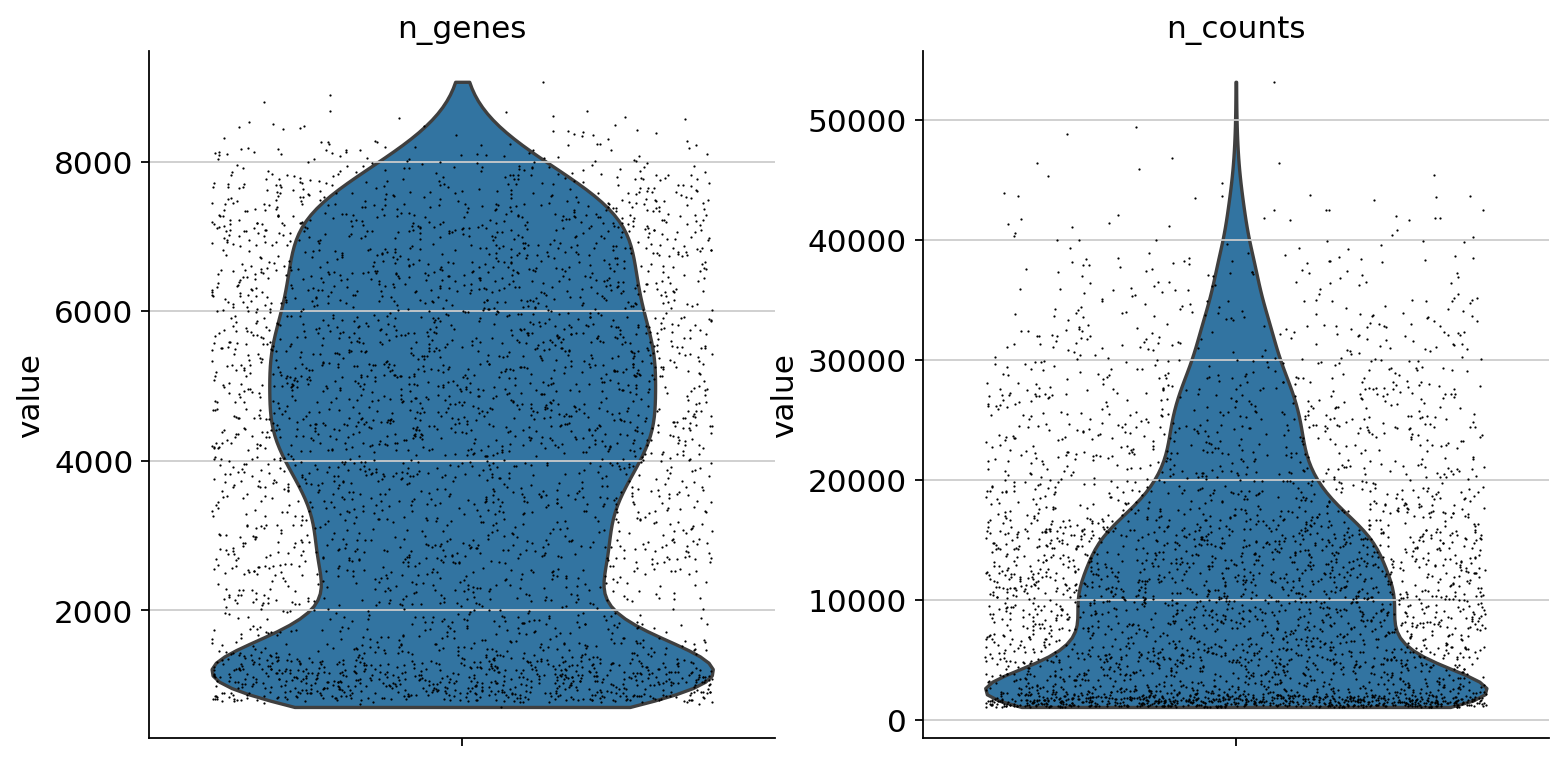

In [51]:
sc.pl.violin(adata, ['n_genes', 'n_counts', ],
             jitter=0.4, multi_panel=True)

In [52]:
#Now it is time to filter


In [53]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

3622 18314


In [54]:
adata

AnnData object with n_obs × n_vars = 3622 × 18314
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id', 'gene_name', 'n_cells', 'mt', 'ribo', 'hb'

In [36]:
#doublets?

In [55]:
#normalize counts

In [56]:
sc.pp.normalize_total(adata, target_sum=10000)

normalizing counts per cell
    finished (0:00:00)


In [57]:
#log the counts

In [59]:
sc.pp.log1p(adata)

In [60]:
#Examine high expressed genes

normalizing counts per cell
    finished (0:00:00)


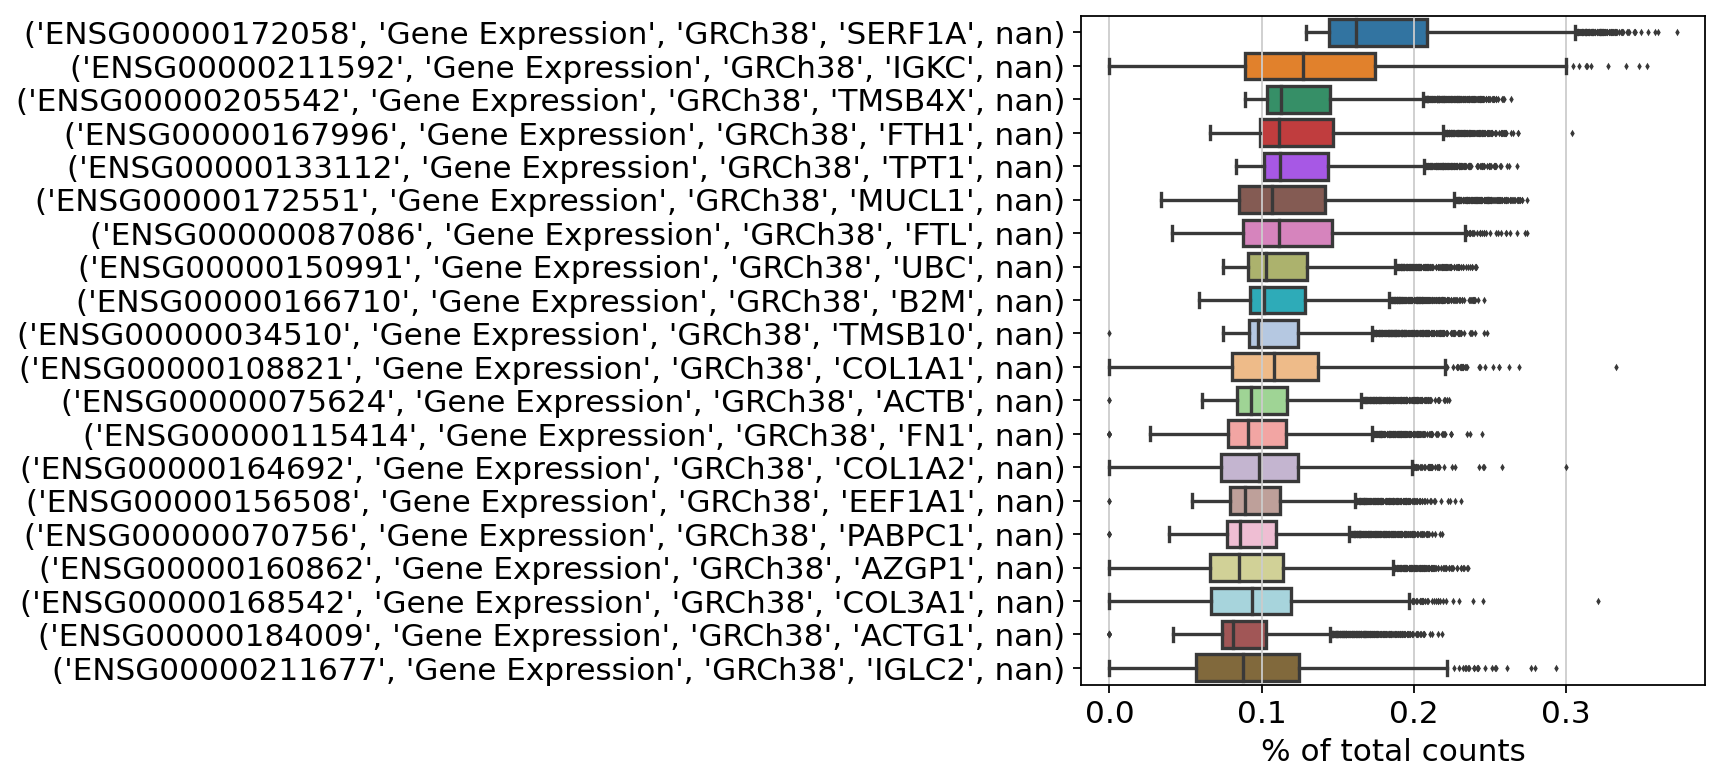

In [61]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [62]:
adata.raw=adata

In [63]:
#Identify high varable genes

In [64]:
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1,n_top_genes=2000, flavor="cell_ranger", n_bins=20)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


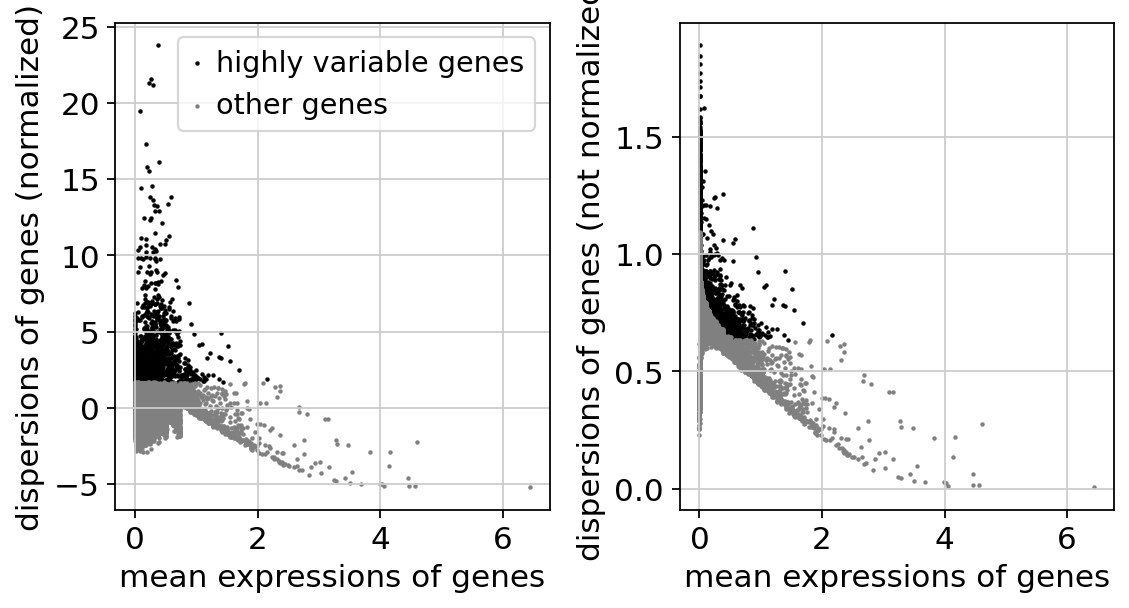

In [65]:
sc.pl.highly_variable_genes(adata)

In [66]:
#regress?

In [67]:
#scaling the data

In [68]:
sc.pp.scale(adata, max_value=20)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [69]:
#PCA on higly varable genes

In [70]:
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


In [104]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.louvain(adata)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [105]:
sc.pl.pca(adata, color='louvain', ax=ax)
#color is a problem

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


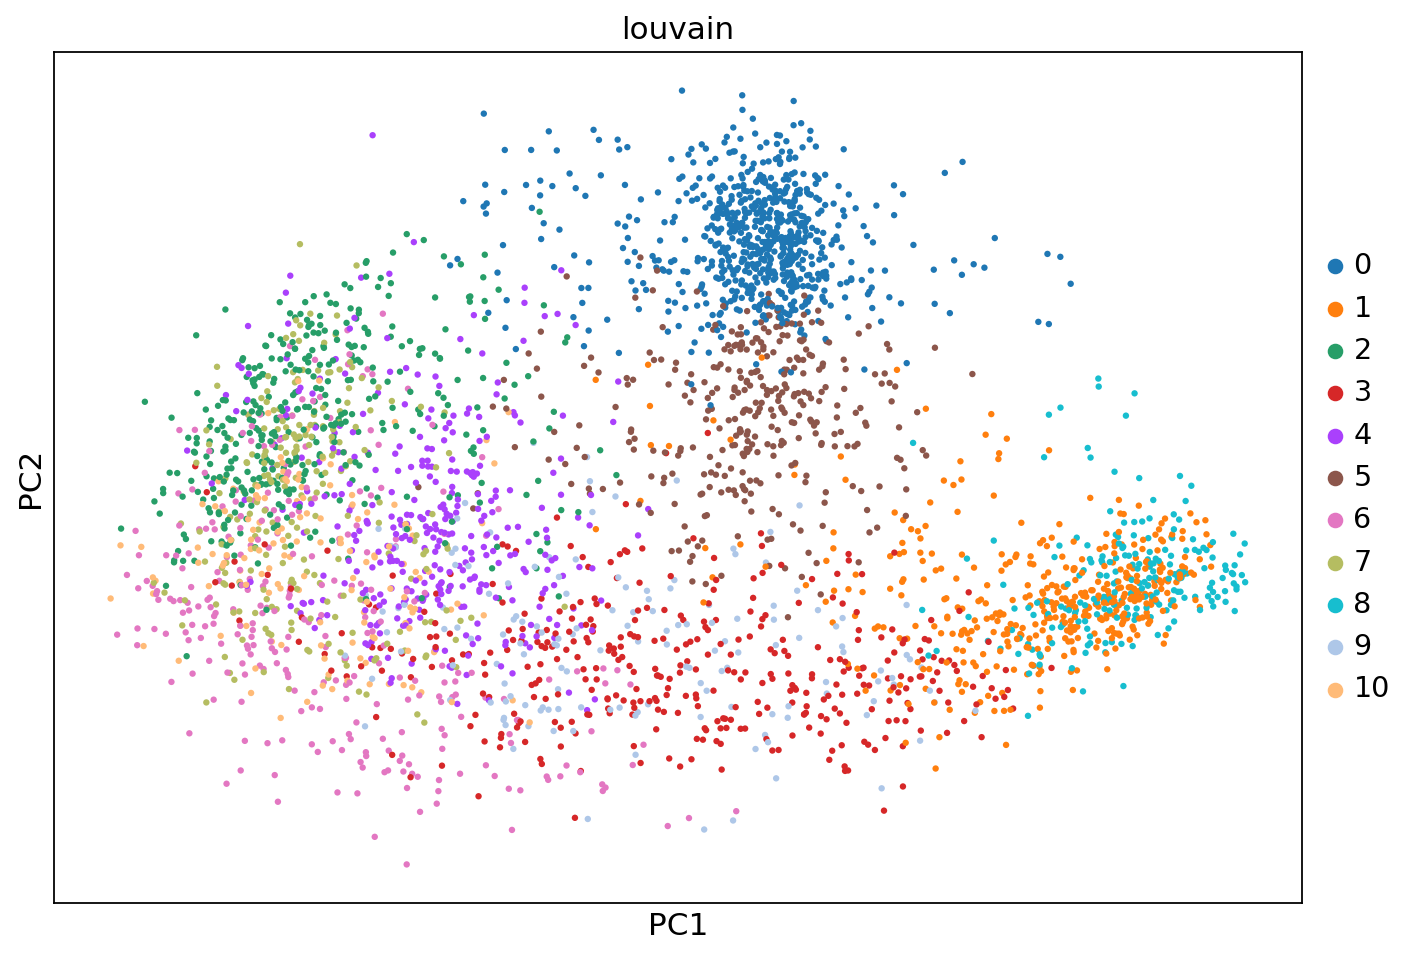

In [106]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

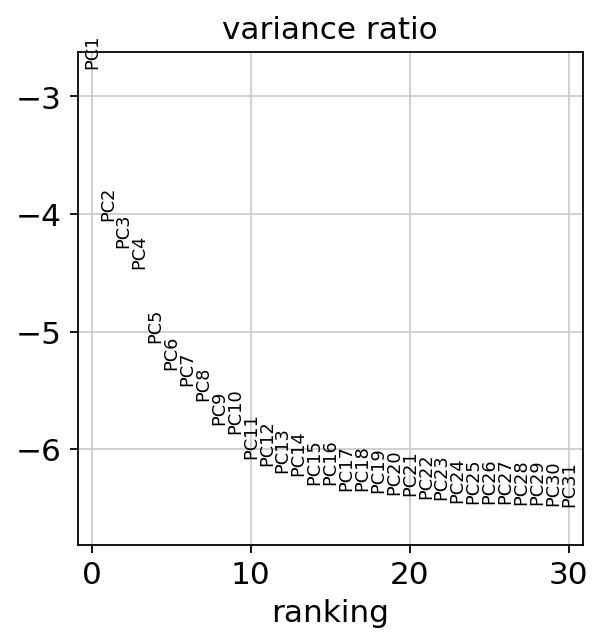

In [107]:
sc.pl.pca_variance_ratio(adata, log=True)

In [108]:
adata

AnnData object with n_obs × n_vars = 3622 × 18314
    obs: 'n_genes', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id', 'gene_name', 'n_cells', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [91]:
#neighborhood graph


In [96]:
#embed the neighborhood graph --already done above

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


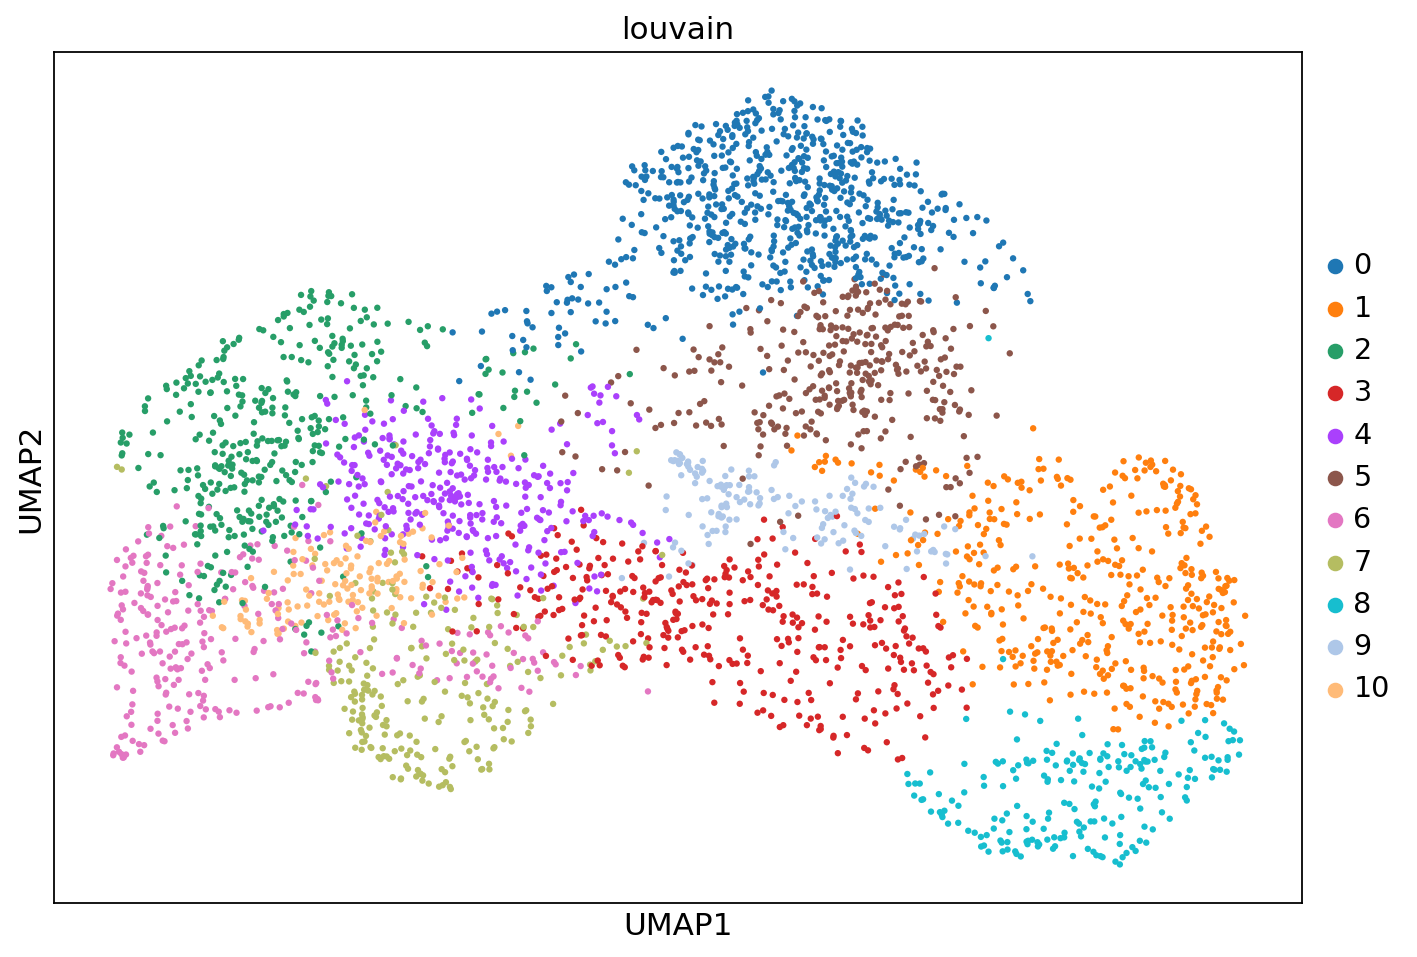

In [111]:
sc.tl.umap(adata)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

In [112]:
#Find marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


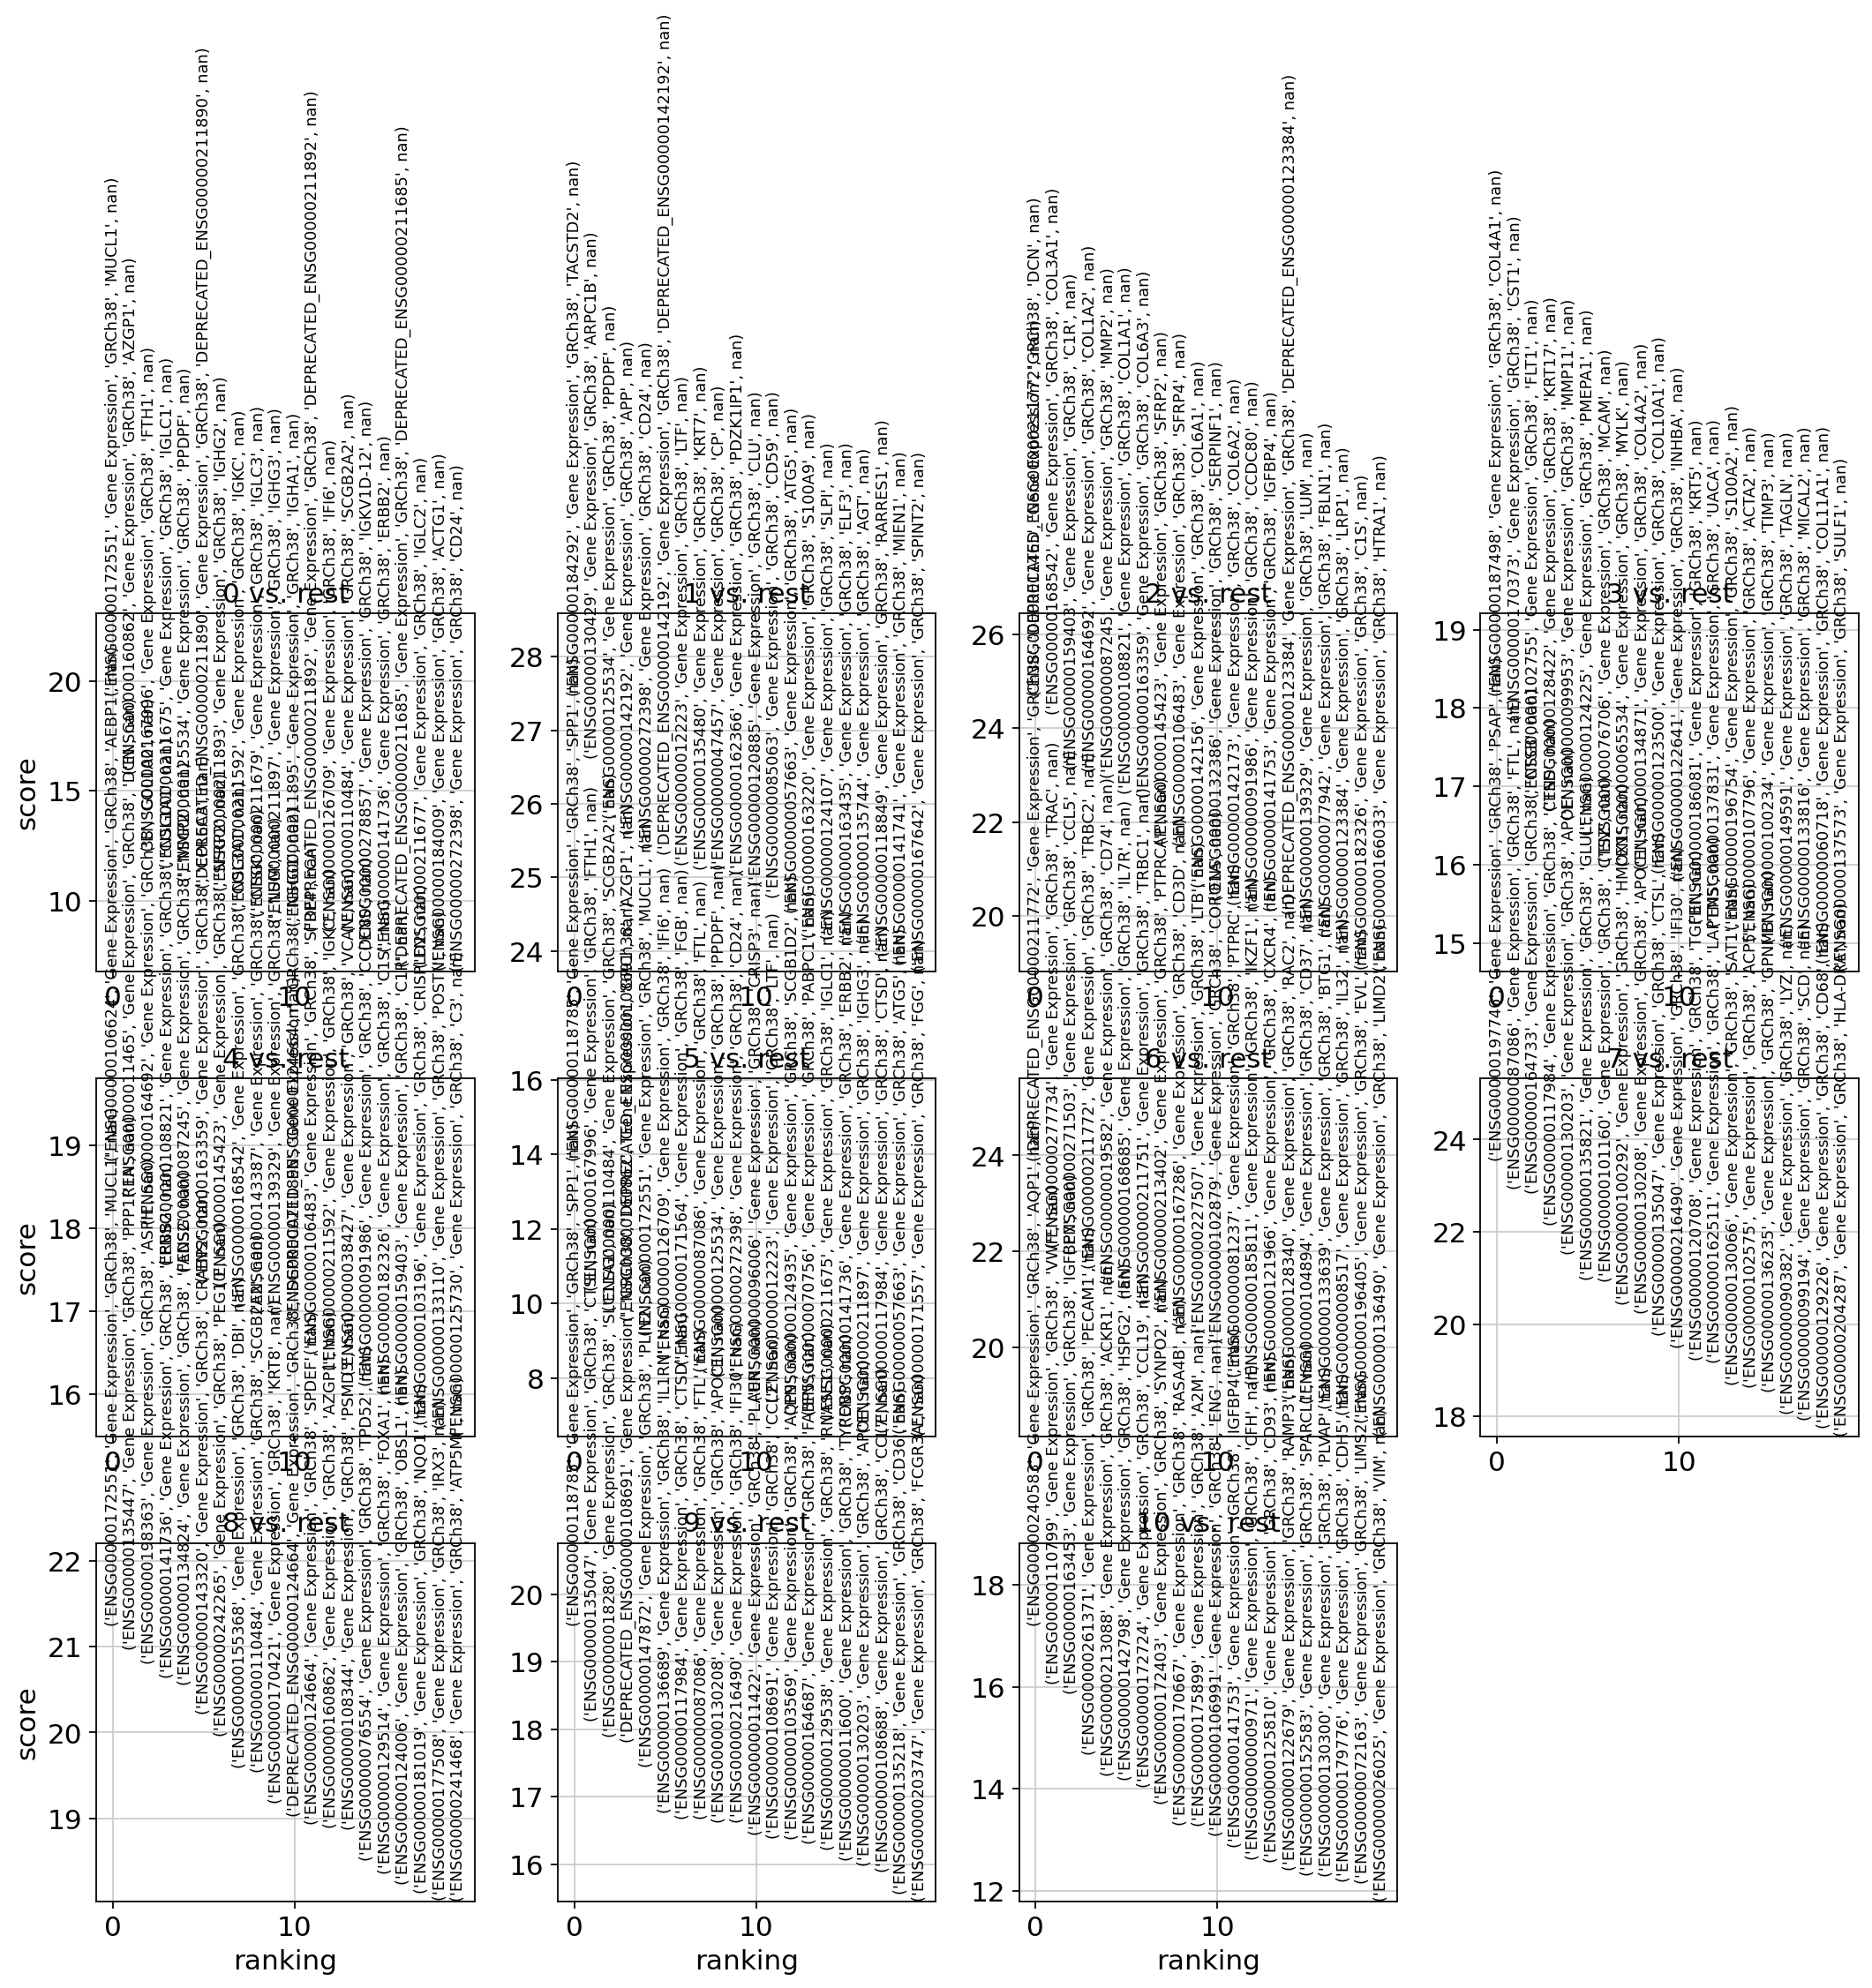

In [116]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [117]:

pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0  \
0  (ENSG00000172551, Gene Expression, GRCh38, MUC...   
1  (ENSG00000160862, Gene Expression, GRCh38, AZG...   
2  (ENSG00000167996, Gene Expression, GRCh38, FTH...   
3  (ENSG00000211675, Gene Expression, GRCh38, IGL...   
4  (ENSG00000125534, Gene Expression, GRCh38, PPD...   

                                                   1  \
0  (ENSG00000184292, Gene Expression, GRCh38, TAC...   
1  (ENSG00000130429, Gene Expression, GRCh38, ARP...   
2  (ENSG00000125534, Gene Expression, GRCh38, PPD...   
3  (ENSG00000142192, Gene Expression, GRCh38, APP...   
4  (ENSG00000272398, Gene Expression, GRCh38, CD2...   

                                                   2  \
0  (ENSG00000011465, Gene Expression, GRCh38, DCN...   
1  (ENSG00000168542, Gene Expression, GRCh38, COL...   
2  (ENSG00000159403, Gene Expression, GRCh38, C1R...   
3  (ENSG00000164692, Gene Expression, GRCh38, COL...   
4  (ENSG00000087245, Gene Expression, GRCh38, MMP...   

                                                   3  \
0  (ENSG00000187498, Gene Expression, GRCh38, COL...   
1  (ENSG00000170373, Gene Expression, GRCh38, CST...   
2  (ENSG00000102755, Gene Expression, GRCh38, FLT...   
3  (ENSG00000128422, Gene Expression, GRCh38, KRT...   
4  (ENSG00000099953, Gene Expression, GRCh38, MMP...   

                                                   4  \
0  (ENSG00000106624, Gene Expression, GRCh38, AEB...   
1  (ENSG00000011465, Gene Expression, GRCh38, DCN...   
2  (ENSG00000164692, Gene Expression, GRCh38, COL...   
3  (ENSG00000108821, Gene Expression, GRCh38, COL...   
4  (ENSG00000087245, Gene Expression, GRCh38, MMP...   

                                                   5  \
0  (ENSG00000118785, Gene Expression, GRCh38, SPP...   
1  (ENSG00000167996, Gene Expression, GRCh38, FTH...   
2  (ENSG00000110484, Gene Expression, GRCh38, SCG...   
3  (ENSG00000160862, Gene Expression, GRCh38, AZG...   
4  (ENSG00000172551, Gene Expression, GRCh38, MUC...   

                                                   6  \
0  (DEPRECATED_ENSG00000211772, Gene Expression, ...   
1  (ENSG00000277734, Gene Expression, GRCh38, TRA...   
2  (ENSG00000271503, Gene Expression, GRCh38, CCL...   
3  (ENSG00000211772, Gene Expression, GRCh38, TRB...   
4  (ENSG00000019582, Gene Expression, GRCh38, CD7...   

                                                   7  \
0  (ENSG00000197746, Gene Expression, GRCh38, PSA...   
1  (ENSG00000087086, Gene Expression, GRCh38, FTL...   
2  (ENSG00000164733, Gene Expression, GRCh38, CTS...   
3  (ENSG00000117984, Gene Expression, GRCh38, CTS...   
4  (ENSG00000130203, Gene Expression, GRCh38, APO...   

                                                   8  \
0  (ENSG00000172551, Gene Expression, GRCh38, MUC...   
1  (ENSG00000135447, Gene Expression, GRCh38, PPP...   
2  (ENSG00000198363, Gene Expression, GRCh38, ASP...   
3  (ENSG00000141736, Gene Expression, GRCh38, ERB...   
4  (ENSG00000134824, Gene Expression, GRCh38, FAD...   

                                                   9  \
0  (ENSG00000118785, Gene Expression, GRCh38, SPP...   
1  (ENSG00000135047, Gene Expression, GRCh38, CTS...   
2  (ENSG00000018280, Gene Expression, GRCh38, SLC...   
3  (DEPRECATED_ENSG00000108691, Gene Expression, ...   
4  (ENSG00000147872, Gene Expression, GRCh38, PLI...   

                                                  10  
0  (ENSG00000240583, Gene Expression, GRCh38, AQP...  
1  (ENSG00000110799, Gene Expression, GRCh38, VWF...  
2  (ENSG00000163453, Gene Expression, GRCh38, IGF...  
3  (ENSG00000261371, Gene Expression, GRCh38, PEC...  
4  (ENSG00000213088, Gene Expression, GRCh38, ACK...

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


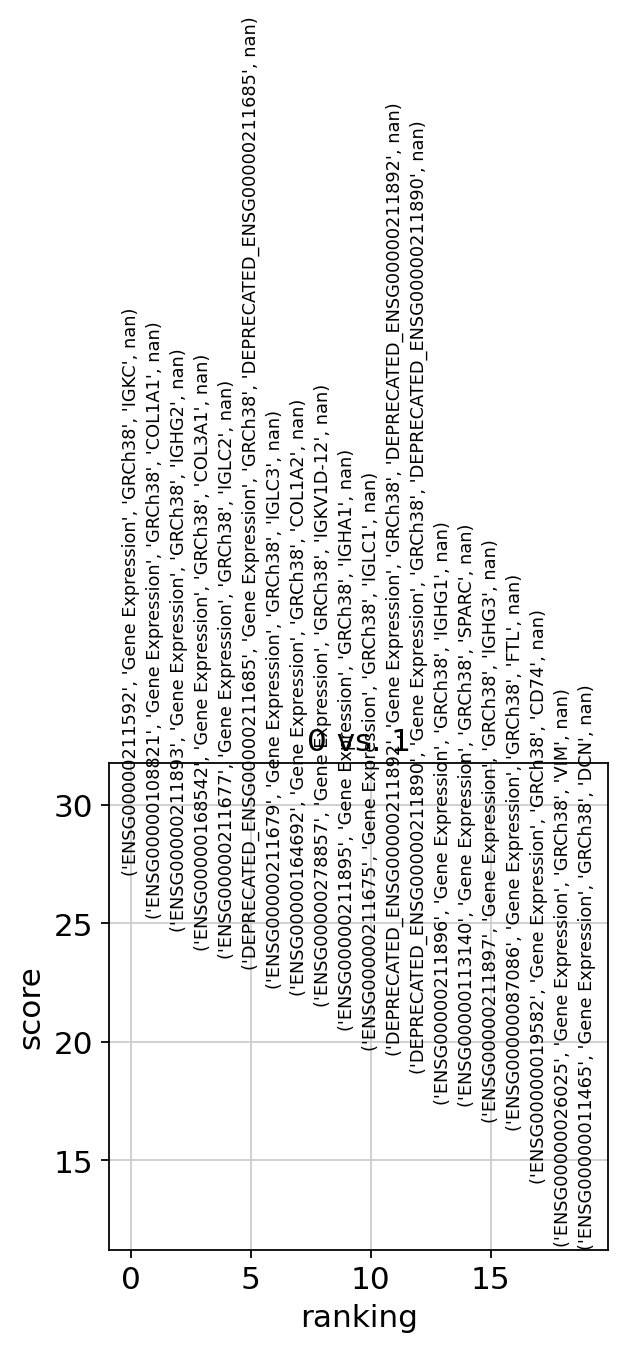

In [118]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)